# Class Activation Map(CAM)을 만들고 평가

## - 목차
1. 데이터셋 준비
2. CAM 모델 생성 및 학습
3. 학습된 모델에서 CAM 생성
4. Detection with CAM
5. IoU

- 프로젝트 정리

In [1]:
import os
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [3]:
#gpu 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. 데이터셋 준비
- 바운딩박스 정보를 포함하고 있는 tensorflow datasets인 caltech_birds2011 데이터셋을 사용.
- caltech_birds2011은 200 종의 새 사진이 총 11,788 장있으며 데이터셋은 5,994장의 학습용 데이터셋과 5,794장의 평가용 데이터셋으로 구성되어 있음.
- 바운딩박스 뿐 만 아니라 segmentation 라벨도 포함되어 있는 데이터셋임.

In [2]:
import urllib3
urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'caltech_birds2011',
    data_dir = os.getenv('HOME') + '/aiffel/caltech_birds2011',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [9]:
#클래스와 인덱스 확인
#tfds.visualization.show_examples(ds_train, ds_info)

- dog 데이터셋처럼 클래스와 인덱스를 시각화 해 보고 싶었으나 segmentation mask 때문에 tfds.show_examples가 오류가 나서 데이터를 시각화 하지 못했다.

In [10]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=200),
    'label_name': Text(shape=(), dtype=tf.string),
    'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
})

## 2. CAM 모델 생성 및 학습

### 2.1 CAM위한 모델 만들기
- 미리 이미지넷(ImageNet) 데이터에 훈련된 ResNet50을 기반으로 하고, 이후 pooling layer 뒤에 소프트맥스 레이어(소프트맥스 함수를 활성화 함수로 사용하는 fully connected 레이어)를 붙여 Grad-CAM 모델을 만들 것.

In [11]:
#ResNet50 뒤에 필요한 레이어를 붙여 CAM을 구하기 위한 기본 모델을 완성
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     #Imagenet 분류기 fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    #ResNet50의 매개변수 pooling에 'avg'를 매개변수로 전달함으로써 쉽게 GAP 연산을 붙일 수 있음
    pooling='avg',      #GAP 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94773248/94765736 [==============================] - 0s 0us/step


In [12]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

### 2.2. CAM 모델 학습
- 학습 데이터와 검증 데이터에 normalizing과 resizing을 포함한 간단한 전처리를 normalize_and_resize_img() 에서 수행.
- 이를 포함하여 apply_normalize_on_dataset()에서 배치를 구성

In [3]:

#bbox 정보가 포함되어있지만, 지금 수행해야 할 CAM 모델의 학습에는 필요가 없으므로 normalize_and_resize_img과정에서 제외함.
def normalize_and_resize_img(input):
    #Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [14]:
#데이터셋에 전처리와 배치처리를 적용. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

#구성된 배치의 모양을 확인. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [15]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [16]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
374/374 [==============================] - 218s 502ms/step - loss: 4.8119 - accuracy: 0.0937 - val_loss: 5.4765 - val_accuracy: 0.0048
Epoch 2/15
374/374 [==============================] - 221s 593ms/step - loss: 1.8826 - accuracy: 0.5832 - val_loss: 4.0118 - val_accuracy: 0.1438
Epoch 3/15
374/374 [==============================] - 187s 500ms/step - loss: 0.6713 - accuracy: 0.8836 - val_loss: 1.7515 - val_accuracy: 0.5372
Epoch 4/15
374/374 [==============================] - 187s 501ms/step - loss: 0.2380 - accuracy: 0.9739 - val_loss: 1.5012 - val_accuracy: 0.6015
Epoch 5/15
374/374 [==============================] - 188s 502ms/step - loss: 0.0854 - accuracy: 0.9968 - val_loss: 1.4161 - val_accuracy: 0.6233
Epoch 6/15
374/374 [==============================] - 187s 501ms/step - loss: 0.0424 - accuracy: 0.9994 - val_loss: 1.4228 - val_accuracy: 0.6198
Epoch 7/15
374/374 [==============================] - 187s 502ms/step - loss: 0.0296 - accuracy: 1.0000 - val_loss: 1.4358 -

In [17]:
#학습시킨 가중치 저장
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map1/cam_model.h5'
cam_model.save(cam_model_path)
print("Save completed")

Save completed


## 3. 학습된 모델에서 CAM 생성

### 3.1 CAM

In [72]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

28


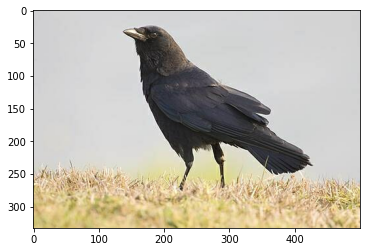

In [73]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [74]:
#이전에 학습한 모델 로드
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map1/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [75]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    #학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의.
    #model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있음.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        #W * f 를 통해 class별 activation map을 계산.
        cam_image += w * conv_outputs[:, :, i]
    
    #activation score를 normalize.
    cam_image /= np.max(cam_image) 
    cam_image = cam_image.numpy()
    #원래 이미지의 크기로 resize.
    cam_image = cv2.resize(cam_image, (width, height)) 
    
    return cam_image

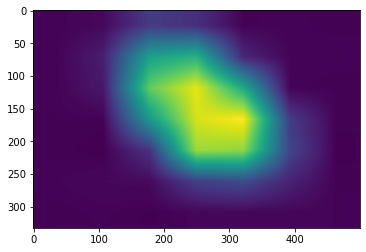

In [76]:
#CAM 이미지 생성
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [77]:
#그려진 CAM과 원본 이미지 합침
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    
    return merged_image

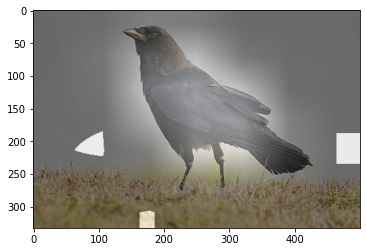

In [78]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

### 3.2 Grad-CAM

In [79]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    #특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의.
    #해당 레이어의 이름으로 찾은 후 output으로 추가.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    #Gradient를 얻기 위해 tape를 사용.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] #원하는 class(여기서는 정답으로 활용) 예측값을 얻음.
        output = conv_output[0] #원하는 layer의 output을 얻음.
        grad_val = tape.gradient(loss, conv_output)[0] #예측값에 따른 Layer의 gradient를 얻음.

    weights = np.mean(grad_val, axis=(0, 1)) #gradient의 GAP으로 class별 weight를 구함.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        #각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻음.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    
    return grad_cam_image

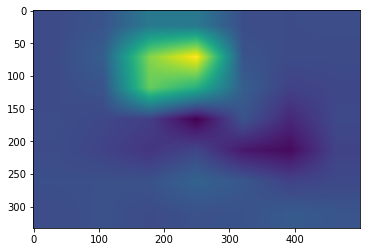

In [80]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

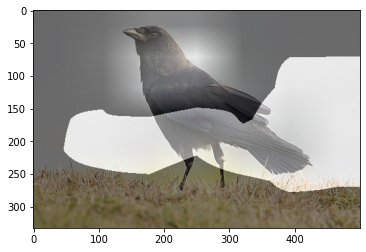

In [81]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

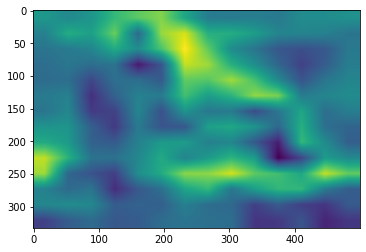

In [82]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

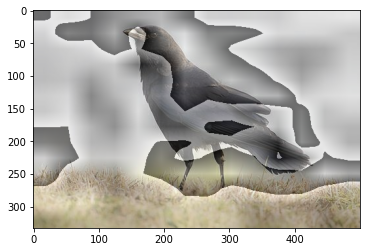

In [83]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

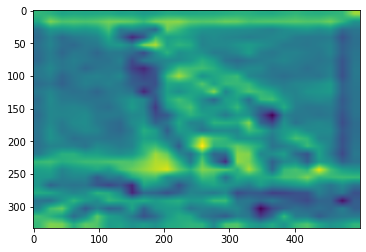

In [84]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

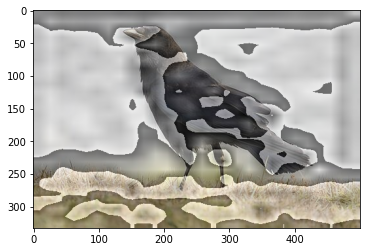

In [85]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

## 4. Detection with CAM

146


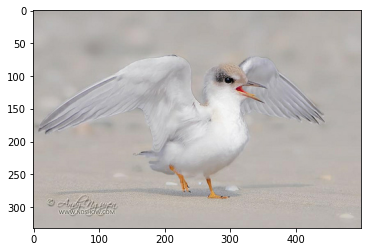

In [86]:
#새로운 이미지
item = get_one(ds_test)
print(item['label'])

plt.imshow(item['image'])
plt.show()

### 4.1 CAM

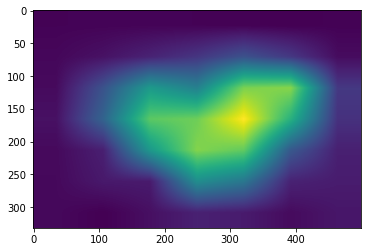

In [87]:
#CAM 이미지
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [91]:
#바운딩 박스를 만들기 위해서 score_thresh를 받아 역치값 이하의 바운딩 박스는 없앰.
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    #OpenCV의 findContours()와 minAreaRect()로 사각형을 찾음.
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    
    #rotated_rect 라는 회전된 바운딩 박스를 얻을 수 있음.
    rect = cv2.boxPoints(rotated_rect)   #boxPoints()로 이를 꼭지점으로 바꾸어 줌.
    rect = np.int0(rect)
    
    return rect

In [92]:
ige = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[ 39,  33],
       [499,  33],
       [499, 331],
       [ 39, 331]])

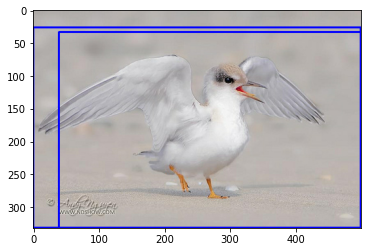

In [103]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)
plt.show()

### 4.2 Grad-CAM

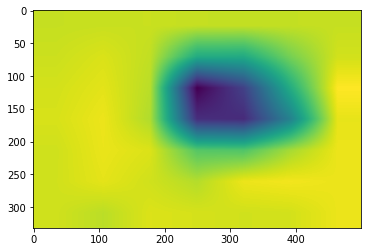

In [94]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

In [95]:
image = copy.deepcopy(item['image'])
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[  0,  26],
       [499,  26],
       [499, 331],
       [  0, 331]])

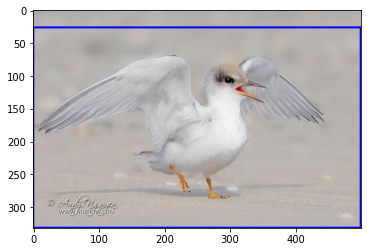

In [96]:
image = cv2.drawContours(image,[grad_rect],0,(0,0,255),2)
plt.imshow(image)

## 5. IoU(Intersection over Union)
- IoU(Intersection over Union)는 두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union 영역으로 나누어준 값임.
- CAM 추론 결과로 얻어진 bbox가 ground truth bbox 얼마나 유사한지를 IoU를 계산해서 확인함.
- 이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있으므로, 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 됨.

In [45]:
#rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어짐. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    
    return bbox

In [98]:
#ground truth bbox
item['bbox']

array([0.19578314, 0.012     , 0.86445785, 0.89      ], dtype=float32)

In [99]:
#CAM bbox
#위에서 구했던 rect를 minmax bbox 형태로 치환
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.09939759036144578, 0.078, 0.9969879518072289, 0.998]

In [100]:
#Grad-CAM bbox
grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])
grad_pred_bbox

[0.0783132530120482, 0.0, 0.9969879518072289, 0.998]

In [49]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [101]:
#CAM bbox와 정답 bbox의 IoU
get_iou(pred_bbox, item['bbox'])

0.6241568807646495

In [102]:
#Grad-CAM bbox와 정답 bbox의 IoU
get_iou(grad_pred_bbox, item['bbox'])

0.6403495598146396

---

## - 프로젝트 정리

| | CAM | Grad-CAM |   
| :--: | :--: | :--: |   
| image | ![original](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/gd06/results/original.JPG?raw=true) | ![original](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/gd06/results/original.JPG?raw=true) |   
| Class activation map| ![cam](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/gd06/results/cam.JPG?raw=true) | ![grad](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/gd06/results/grad.JPG?raw=true) |   
| BBox | ![cam](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/gd06/results/cam_bb.JPG?raw=true) | ![grad](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/gd06/results/grad_bb.JPG?raw=true) |   
| IoU | 0.6241568807646495 | 0.6403495598146396 |

- Class activation map을 비교하면 CAM 방식은 전반적인 면적인 반면에 Grad-CAM 방식은 특정 부분에만 집중되어 있는 것을 볼 수 있다.
- 바운딩 박스의 결과는 Grad-CAM 방식이 detection을 제대로 한 결과를 보인 반면, CAM 방식은 바운딩 박스가 제대로 된 결과라고 보기 힘든 겹쳐진 모양으로 나왔다. 겹쳐서 나온 이유는 잘 모르겠으나 detection이 제대로 되었다고 하긴 힘들 것 같다.
- IoU를 보면 Grad-CAM 방식이 좀 더 높은 점수를 얻었다. 아무래도 CAM 방식보다 Grad-CAM의 바운딩박스가 detection을 잘 했기 때문인 것 같다.